# [TRL - Transformer Reinforcement Learning](https://huggingface.co/docs/trl/index)
- `Supervised Fine-tuning, (SFT)`, `Reward Modeling, (RM)`, `the Proximal Policy Optimization, (PPO)` 까지 제공할 수 있는 Transformer 언어 모델 학습용 라이브러리

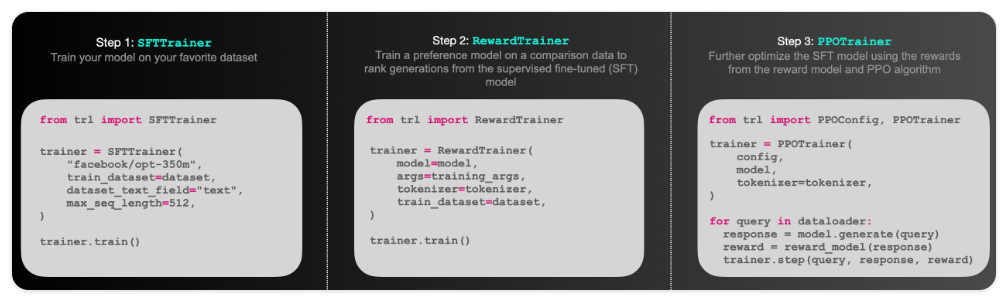

## Trainer vs SFTTrainer
LLM 파인튜닝을 위해 `TRL 라이브러리`의 `Trainer 클래스` 또는 `SFTTrainer 클래스`를 많이 이용하는 추세입니다. 두 가지 클래스의 장점 및 차이점은 다음과 같습니다.

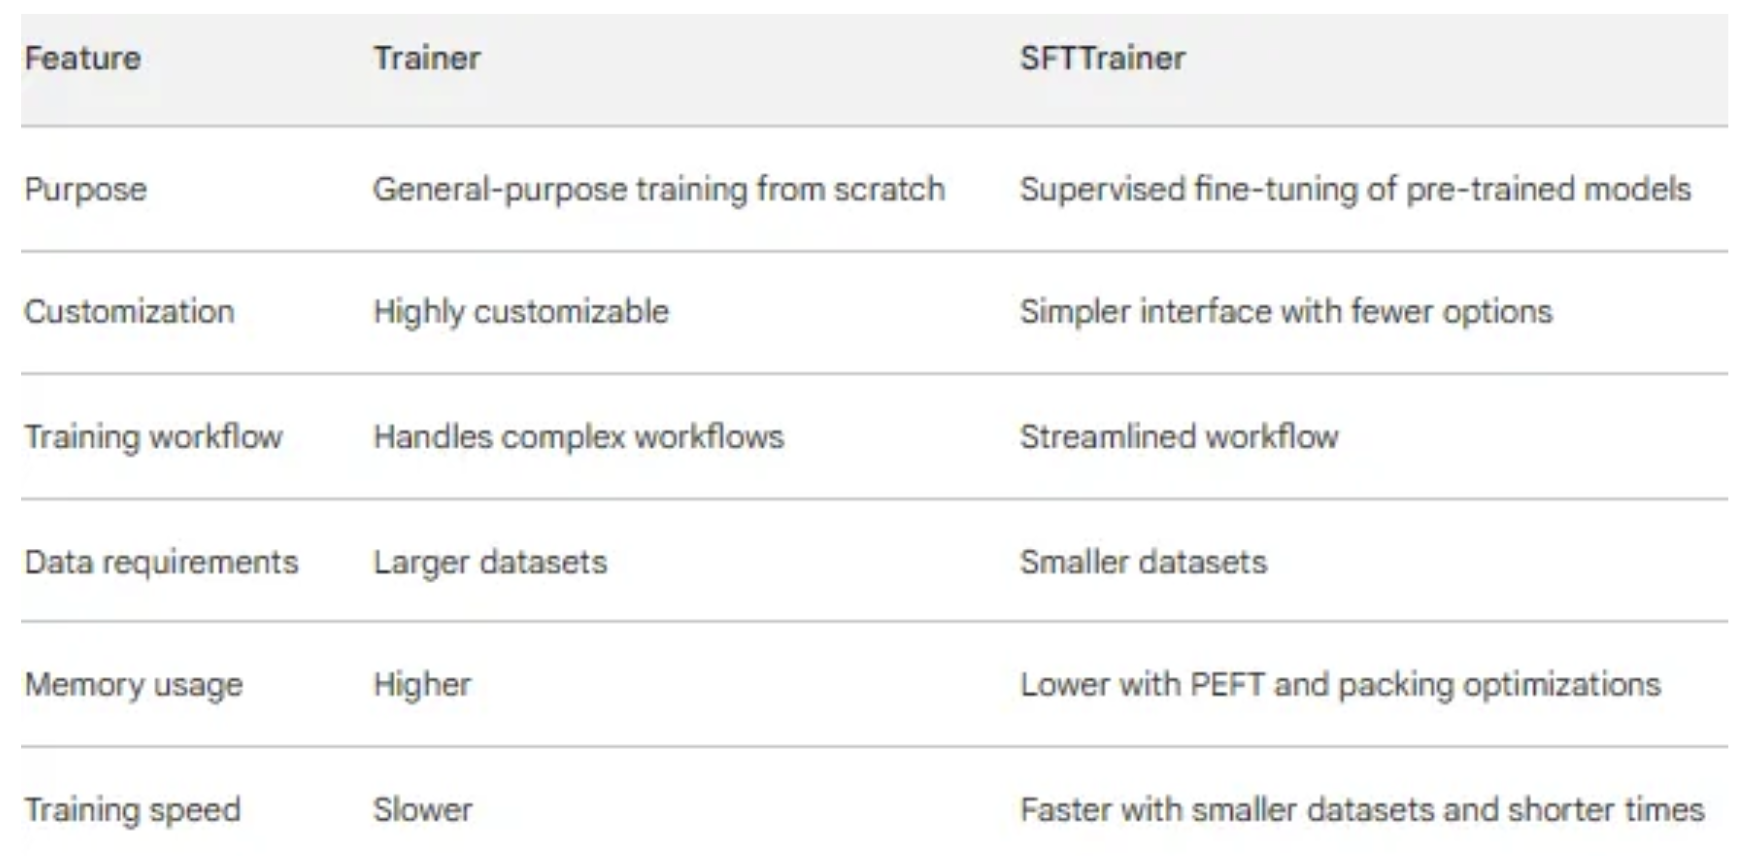

### Trainer

- `일반적인 목적의 학습`: 텍스트 분류, QA, 요약과 같은 지도 학습에 대해 처음부터 모델을 학습하도록 설계됨
- `고도화된 커스터마이징`: hyperparameters, optimizers, schedulers, logging, 평가 지표를 파인튜닝하기 위한 광범위한 config 옵션 제공
- `복잡한 학습 워크플로우 처리`: gradient accumulation, early stopping, checkpointing, 분산학습 등 기능 지원
- `더 많은 데이터 필요`: 일반적으로 처음부터 효과적인 학습을 위해 더 큰 데이터셋 필요

### SFTTrainer

- `Supervised Fine-tuning (SFT)`: 지도 학습 작업에서 더 작은 데이터 세트로 사전 학습된 모델을 미세 조정하는 데 최적화
- `간단한 인터페이스`: 더 적은 구성 옵션으로 간소화된 워크플로우를 제공하여 보다 쉽게 시작할 수 있음
- `효율적인 메모리 사용`:
PEFT(parameter-efficient) 및 패킹 최적화(packing optimization)와 같은 기술을 사용하여 학습 중 메모리 소비를 줄임
- `더 빠른 학습`: Trainer 보다 더 작은 데이터셋과 더 짧은 학습 시간으로 더 나은 정확도 달성

### 요약
- `Trainer 사용`: 데이터 세트가 크고 학습 loop 또는 복잡한 학습 워크플로우에 대한 광범위한 사용자 정의가 필요한 경우.
- `SFTTrainer 사용`: 사전 학습된 모델과 상대적으로 작은 데이터셋이 있고 효율적인 메모리 사용으로 더 간단하고 빠른 파인튜닝을 원하는 경우.

## [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer)
- SFT를 위한 Trainer를 제공합니다.
- 해당 Trainer는 기존 huggingface에서 사용하던 trainer와 크게 다르지 않습니다.

아래는 가장 기초적인 호출 방법으로 기존의 Trainer에서 쉽게 보던 모습입니다.
- 모델을 직접 불러와 Trainer에게 넘겨주어도 되고 아래처럼 huggingface에 업로드된 경로 혹은 로컬의 path를 넘겨주면 해당 경로에 있는 모델과 토크나이저를 자동으로 모델이 불러올 수 있게 됩니다.

```python
from datasets import load_dataset
from trl import SFTTrainer

dataset = load_dataset("imdb", split="train")

trainer = SFTTrainer(
    "facebook/opt-350m",
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=512,
)
trainer.train()

```

- TRL에 좋은점은 PEFT를 사용할 수 있게 설계되어 있다는데 있습니다.
- 이 부분이 Finetuning에서 크게 시간을 단축할 수 있는 LoRA를 쉽게 사용할 수 있도록 되어 있습니다.

아래와 같이 peft를 불러와 LoraConfig만 작성하여 SFTTrainer에 넘겨주면 됩니다.

```python
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig

dataset = load_dataset("imdb", split="train")

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

trainer = SFTTrainer(
    "EleutherAI/gpt-neo-125m",
    train_dataset=dataset,
    dataset_text_field="text",
    peft_config=peft_config # PEFT 적용
)

trainer.train()

```

- 여기에 더해 대형 자연어 모델을 불러오기 위한 방법도 적용이 가능합니다.
- 이 방법에서는 Trainer밖에서 모델을 불러오고 Trainer에게 넘겨주어야만 합니다.
- `load_in_8bit` or `load_in_4bit`옵션을 통해 불러오면 되겠습니다.

```python
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

# 외부에서 모델 생성
model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/gpt-neo-125m",
    load_in_8bit=True, # 옵션
    device_map="auto",
)

trainer = SFTTrainer(
    model,
    train_dataset=dataset,
    dataset_text_field="text",
    peft_config=peft_config,
)

trainer.train()
```

# SFTTrainer 예제

## [Alpaca](https://colab.research.google.com/drive/135ced7oHytdxu3N2DNe1Z0kqjyYIkDXp?usp=sharing#scrollTo=2eSvM9zX_2d3)
- 스탠퍼드 대학의 CRFM (Center for Research Foundation Models)는 학술 연구 목적으로 Meta의 LLaMA-7B 모델을 finetuning한 Alpaca라는 모델을 공개했다.

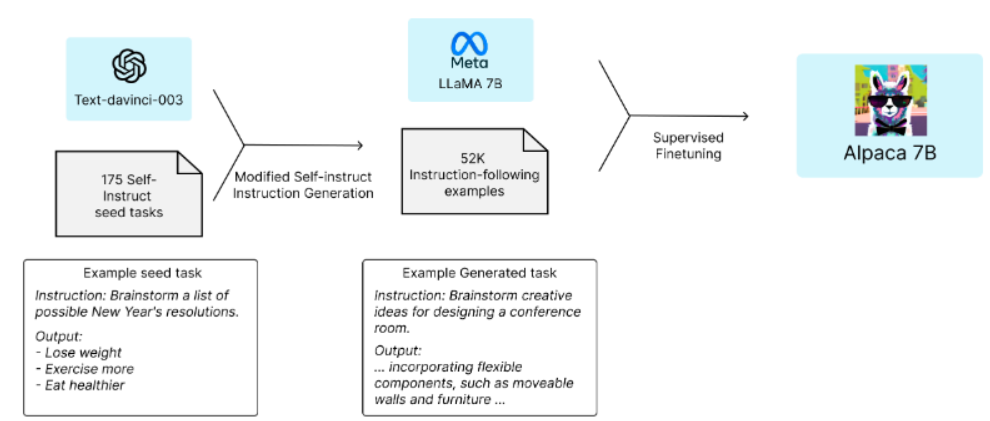

## Setup

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install triton
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes

## Load Model

In [ ]:
from unsloth import FastLanguageModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [ ]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2024.10.2: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Unsloth: We fixed a gradient accumulation bug, but it seems like you don't have the latest transformers version!
Please update transformers via:
`pip uninstall transformers -y && pip install --upgrade --no-cache-dir "git+https://github.com/huggingface/transformers.git"`


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.10.2 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Load Dataset

In [ ]:
alpaca_prompt = """
  Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

  ### Instruction:
  {}

  ### Input:
  {}

  ### Response:
  {}
"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

In [ ]:
from datasets import load_dataset

dataset = load_dataset("yahma/alpaca-cleaned", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

alpaca_data_cleaned.json:   0%|          | 0.00/44.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51760 [00:00<?, ? examples/s]

Map:   0%|          | 0/51760 [00:00<?, ? examples/s]

## SFTTrainer

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

In [ ]:
args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    )

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = args
)

Map (num_proc=2):   0%|          | 0/51760 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
5.613 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

**** Unsloth: Please use our fixed gradient_accumulation_steps by updating transformers and Unsloth!


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 51,760 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.764100
2,2.175000
3,1.693800
4,1.960000
5,1.667800
6,1.583100
7,1.156400
8,1.280200
9,1.106700
10,1.128700


In [ ]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)

print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

114.4729 seconds used for training.
1.91 minutes used for training.
Peak reserved memory = 6.854 GB.
Peak reserved memory for training = 1.241 GB.
Peak reserved memory % of max memory = 17.324 %.
Peak reserved memory for training % of max memory = 3.137 %.


## Inference

In [ ]:
# alpaca_prompt = Copied from above
new_model = FastLanguageModel.for_inference(model) # Enable native 2x faster inference

In [ ]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

['<|begin_of_text|>\n  Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n  ### Instruction:\n  Continue the fibonnaci sequence.\n\n  ### Input:\n  1, 1, 2, 3, 5, 8\n\n  ### Response:\n  \n1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, ']

In [ ]:
outputs = new_model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

### TextStreamer

In [ ]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

<|begin_of_text|>
  Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

  ### Instruction:
  Continue the fibonnaci sequence.

  ### Input:
  1, 1, 2, 3, 5, 8

  ### Response:
  
1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465,


In [ ]:
from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer)
_ = new_model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)